In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from util import get_file_paths
from Vanilla_LSTM import Vanilla_LSTM


In [40]:

file_paths=get_file_paths("./data/valve1")

In [41]:
dfs=[]

for file_path in file_paths:
    df = pd.read_csv(file_path,sep=';',index_col='datetime', parse_dates=True)
    dfs.append(df)
    
# Concatenate all the DataFrames in the list into a single DataFrame
valve1_df = pd.concat(dfs) #, ignore_index=True)


In [42]:
def calc_metrics(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)
  return accuracy,cm,f1,fpr, tpr, thresholds, roc_auc
 


In [43]:
def plot(cm, fpr, tpr, roc_auc, title = 'Model Evaluation Metrics'):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  fig.suptitle(title, fontsize=16, y=1.02)
  
  confusion_matrix_ax = ax[0]
  roc_curve_ax = ax[1]
  
  # Confusion Matrix in the first subplot
  ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=confusion_matrix_ax)
  confusion_matrix_ax.set_title('Confusion Matrix')
  confusion_matrix_ax.set_xlabel('Predicted labels')
  confusion_matrix_ax.set_ylabel('True labels')

  # ROC Curve in the second subplot
  roc_curve_ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
  roc_curve_ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  roc_curve_ax.set_xlabel('False Positive Rate')
  roc_curve_ax.set_ylabel('True Positive Rate')
  roc_curve_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
  roc_curve_ax.legend(loc='lower right')

  # Display the plot
  plt.tight_layout()
  plt.show()
  

In [44]:

# from sklearn.model_selection import train_test_split
# from sklearn.base import clone
# from lightgbm import LGBMClassifier
# import numpy as np

def train_models(x_train, y_train, model, n):
    """
    Trains the model n times on bootstrap samples of the training data.
    
    Parameters:
    - x_train: Features of the training data.
    - y_train: Labels of the training data.
    - model: The machine learning model to be trained.
    - n: The number of times to fit the model on bootstrap samples.
    
    Returns:
    - models: A list of trained models.
    """
    models = []
    for _ in range(n):
        # Bootstrap sample
        x_train_sample, _, y_train_sample, _ = train_test_split(
            x_train, y_train, train_size=1/n, stratify=y_train, random_state=_)
        # Fit model
        model_clone = clone(model)  # Clone the base model to avoid refitting the same model
        model_clone.fit(x_train_sample, y_train_sample)
        models.append(model_clone)
    return models

def test_models(x_test, models, operation_var):
    """
    Runs each model on the test data and calculates the probability of not being an anomaly.
    
    Parameters:
    - x_test: Features of the test data.
    - models: A list of trained models.
    - operation_var: Operation to perform on the probabilities ('max' or 'avg').
    
    Returns:
    - labels: The predicted labels for the test data.
    - test_not_anomaly_proba: The probability of not being an anomaly for each test sample.
    """
  
    probas = []
    for model in models:
        # Predict_proba returns [prob_anomaly, prob_not_anomaly] for binary classification
        prob_not_anomaly = model.predict_proba(x_test)[:, 1]
        probas.append(prob_not_anomaly)
    
    probas = np.array(probas)
    
    # Calculate test_not_anomaly_proba based on operation_var
    if operation_var == 'max':
        test_not_anomaly_proba = np.max(probas, axis=0)
    elif operation_var == 'avg':
        test_not_anomaly_proba = np.mean(probas, axis=0)
    else:
        raise ValueError("operation_var must be 'max' or 'avg'")
    
    # Convert probabilities to labels
    labels = np.where(test_not_anomaly_proba < 0.5, 0, 1)
    
    return labels, test_not_anomaly_proba



total_rows = len(valve1_df)
index_70_percent = int(total_rows * 0.7)
index_90_percent = index_70_percent + int(total_rows * 0.2)

# Split the DataFrame into three parts
test_df = valve1_df.iloc[index_90_percent:] 
train_df = valve1_df.iloc[:index_70_percent]
valid_df = valve1_df.iloc[index_70_percent:index_90_percent]



X_train = train_df.drop('anomaly', axis=1)
y_train = train_df['anomaly']
    

   
model = lgb.LGBMClassifier()  # Base LightGBM model

# hyperparameters selection
# N_STEPS = 5
# EPOCHS = 25
# BATCH_SIZE = 32
# VAL_SPLIT = 0.2
# PARAMS = [N_STEPS, EPOCHS, BATCH_SIZE, VAL_SPLIT]
# model = Vanilla_LSTM(PARAMS)

n = 10  # Number of models to train

# Train sample models
models_list = train_models(X_train, y_train, model, n=n)

X_test = test_df.drop('anomaly', axis=1)
y_test = test_df['anomaly']

max_labels, max_probabilities = test_models(X_test, models_list, operation_var='max')
avg_labels, avg_probabilities = test_models(X_test, models_list, operation_var='avg')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 431, number of negative: 840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 1271, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339103 -> initscore=-0.667294
[LightGBM] [Info] Start training from score -0.667294
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 431, number of negative: 840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1687
[LightGBM] [Info] Number of data points in the train set: 1271, number of used features: 

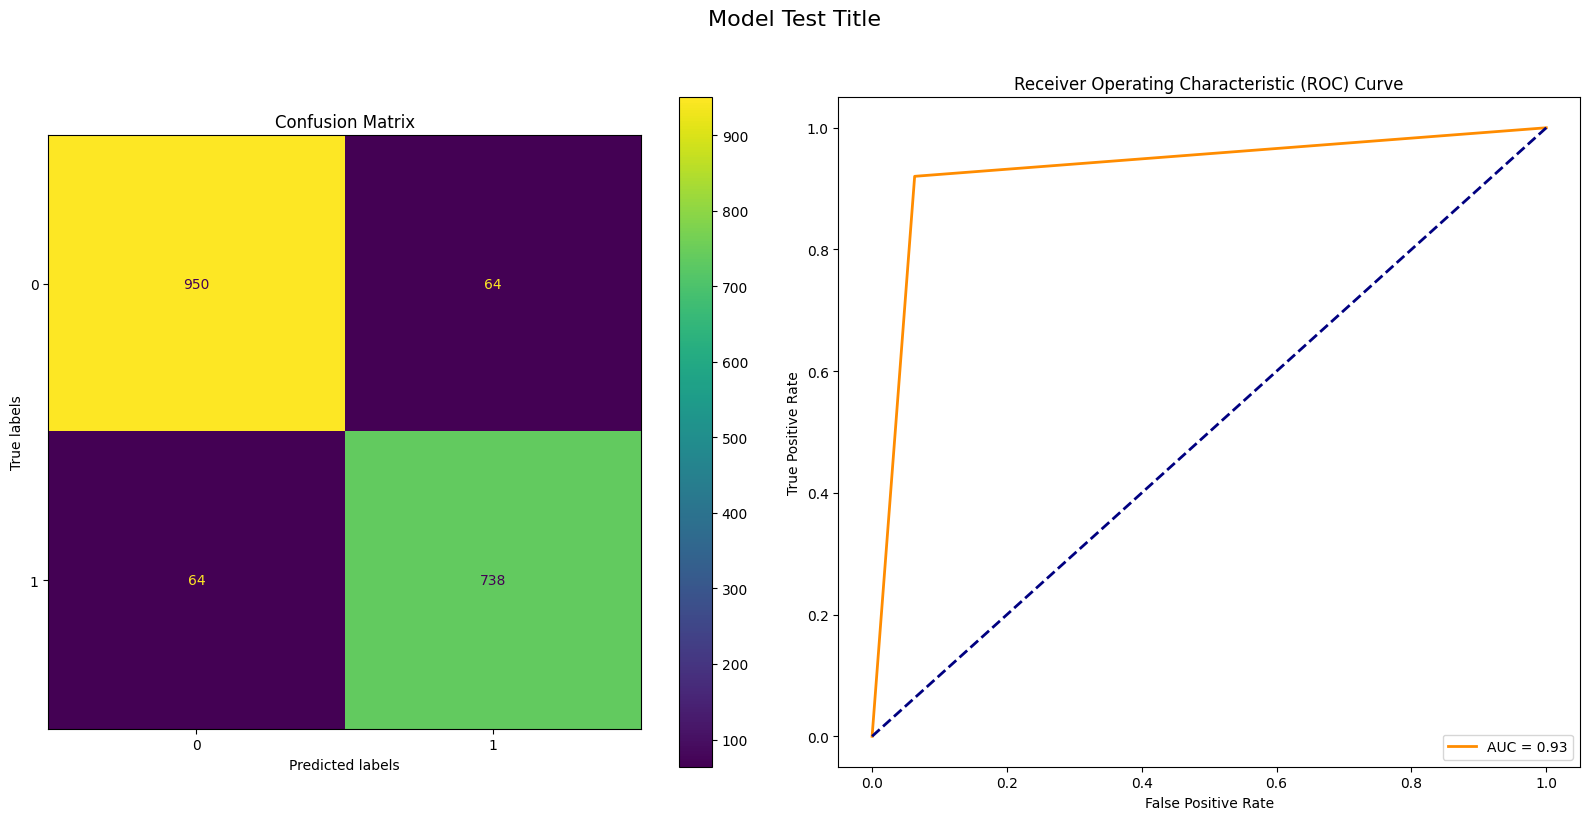

(0.9295154185022027, 0.9201995012468828, array([2, 1, 0]))

In [48]:
# avg_labels, avg_probabilities
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,avg_labels)
plot(cm, fpr, tpr, roc_auc, title = 'Model Test Title')
accuracy, f1, thresholds

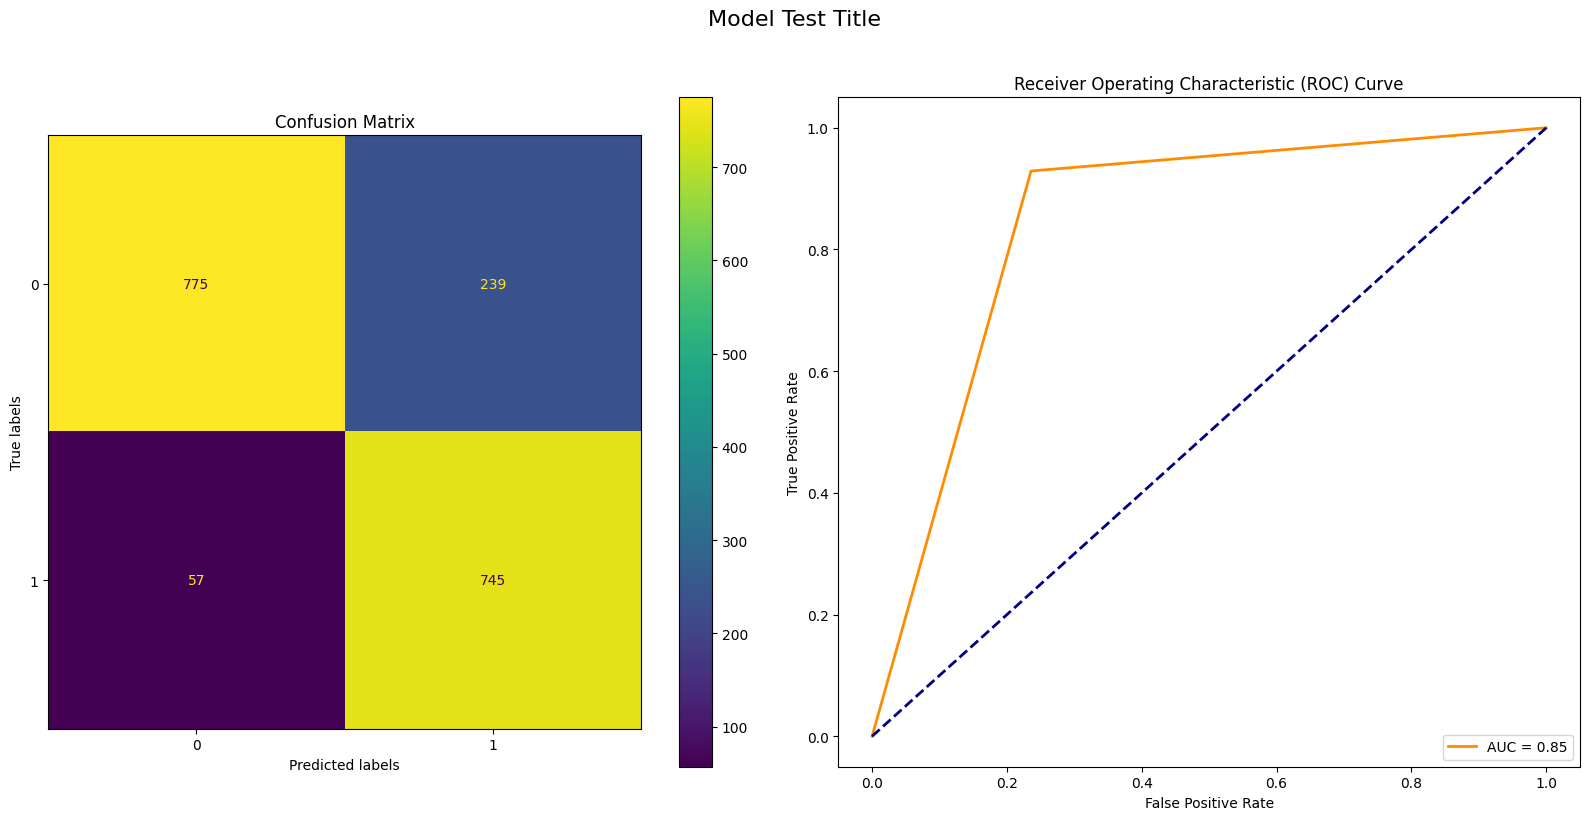

(0.8370044052863436, 0.8342665173572228, array([2, 1, 0]))

In [49]:

# max_labels, max_probabilities
accuracy, cm, f1, fpr, tpr, thresholds, roc_auc = calc_metrics(y_test,max_labels)
plot(cm, fpr, tpr, roc_auc, title = 'Model Test Title')
accuracy, f1, thresholds